# Property-Based Scheduling: Work Order Analysis

This analysis was conducted in order to determine the degree to which the abolishment of Alternate Work Schedules (AWS) for Caretakers affected the number of cleanliness-related work orders created in public space areas at NYCHA sites. The query used to obtain these data is found in the "Data/" directory horizontal to this one.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
import statsmodels.api as sm
from tqdm import tqdm
import os

import datetime as dt
from linearmodels import PanelOLS
from linearmodels import RandomEffects
pd.set_option('display.max_columns', None)

In [2]:
wos = pd.read_excel('Data/PBS_WOs_20220824.xlsx')

/home/kyle/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


This block removes work orders that are not created or monitored directly by the developments under NYCHA management. Such irrelevant work orders include those created by the Department of Management and Planning and those at developments under private management. In addition, date-like columns are converted to datetime format for further analysis.

In [3]:
wos = wos[wos['OWNERGROUP'] != 'DMP']
wos = wos[wos['BORO'] != 'Private Mgmt']
wos = wos[wos['SOURCESYSID'] != 'MAXIMO']
wos = wos[wos['SOURCESYSID'] != 'MOBILE']

for col in ['ZZCREATEDATE', 'REPORTDATE', 'TARGSTARTDATE', 'SCHEDSTART', 'ACTSTART', 'ACTFINISH', 'STATUSDATE']:
    wos[col] = pd.to_datetime(wos[col])

The following block formats our dataset for use in analyses comparing current-year work order trends to those of a year prior, and adds indicator variables for whether, on the date that a work order was created, a site had transitioned away from AWS.

In [30]:
def clean_wo_data(df):
    #Store the dates of conversion for each borough, plus the year-earlier dates
    start_date_dict = {'Manhattan': dt.date(2022,4,3), 'Queens-Staten Island': dt.date(2022,4,4),'Bronx': dt.date(2022,4,17), 'Brooklyn': dt.date(2022,5,16)}
    start_date_dict_yearprior = {'Manhattan': dt.date(2021,4,3), 'Queens-Staten Island': dt.date(2021,4,4),'Bronx': dt.date(2021,4,17), 'Brooklyn': dt.date(2021,5,16)}
    
    #This function determines how many days before or after implementation of Property-Based Schedules a work order was created
    def days_post_implementation(df, date_column, boro_column, start_date_dict = start_date_dict):
        if start_date_dict is not None:
            df['DAYS_AFTER_IMPLEMENTATION'] = df.apply(lambda row: row[date_column]-start_date_dict[row[boro_column]], axis=1)
        else:
            df['DAYS_AFTER_IMPLEMENTATION'] = df.apply(lambda row: row[date_column]-dt.date(1975,1,1), axis=1)
        
        df['DAYS_AFTER_IMPLEMENTATION'] = df['DAYS_AFTER_IMPLEMENTATION'].apply(lambda x: x.days)
        
        return df
    
    #This function replicates the above functionality for year-earlier dates, determining, for each date, whether PBS had been put in place
        #by the same date in the following year
    def yoy_comp_prepost(df, date_column, boro_column, start_date_dict = start_date_dict_yearprior):
        if start_date_dict is not None:
            df['YOY_DAYS_AFTER_IMPLEMENTATION'] = df.apply(lambda row: row[date_column]-start_date_dict[row[boro_column]], axis=1)
        else:
            df['YOY_DAYS_AFTER_IMPLEMENTATION'] = df.apply(lambda row: row[date_column]-dt.date(1975,1,1), axis=1)
        
        df['YOY_DAYS_AFTER_IMPLEMENTATION'] = df['YOY_DAYS_AFTER_IMPLEMENTATION'].apply(lambda x: x.days)
        
        return df
    
    df['FCPC'] = df.apply(lambda row: row['FAILURECODE']+'-'+row['PROBLEMCODE'], axis=1)
    df['DAY_CREATED'] = df['ZZCREATEDATE'].apply(lambda x: x.date())
    
    df = days_post_implementation(df, 'DAY_CREATED', 'BORO')
    df = yoy_comp_prepost(df, 'DAY_CREATED', 'BORO')
    
    df['PRE_POST_IND'] = df['DAYS_AFTER_IMPLEMENTATION'].apply(lambda x: 'POST' if x>=0 else 'PRE')
    df['YOY_PRE_POST_IND'] = df['YOY_DAYS_AFTER_IMPLEMENTATION'].apply(lambda x: 'POST' if x>=0 else 'PRE')
    
    return df

In [5]:
wos_clean = clean_wo_data(wos)

The following block calculates the total number of work orders created at each development _n_ days after implementation. In effect, this shifts our dataset from an absolute date scale to a relative date scale, which makes it easier for us to compare the impact of PBS across boroughs.

In [6]:
t = wos_clean[['WONUM','DEVELOPMENT_NAME','DAYS_AFTER_IMPLEMENTATION','PRE_POST_IND','DAY_CREATED']].groupby(['DAYS_AFTER_IMPLEMENTATION','DEVELOPMENT_NAME']).agg({'WONUM':'count', 'PRE_POST_IND':'first', 'DAY_CREATED':'first'}).reset_index()
t = t[(t['DAYS_AFTER_IMPLEMENTATION']<=30) & (t['DAYS_AFTER_IMPLEMENTATION']>=-30)]

Because the `groupby()` call above removes any development-date combinations for which there are no work orders, we must manually add back entries for those combinations, setting the associated work order count to 0.

In [7]:
print(t.shape)
devs = list(t['DEVELOPMENT_NAME'].unique())
days = list(t['DAYS_AFTER_IMPLEMENTATION'].unique())

for dev in tqdm(devs):
    for day in days:
        if t[(t['DEVELOPMENT_NAME']==dev)&(t['DAYS_AFTER_IMPLEMENTATION']==day)].shape[0] == 0:
            if day < 0:
                pp = 'PRE'
            else:
                pp = 'POST'
            t = pd.concat([t, pd.DataFrame({'DAYS_AFTER_IMPLEMENTATION':[day], 'DEVELOPMENT_NAME':[dev], 'WONUM':[0],
       'PRE_POST_IND':[pp]})])


(2556, 5)


100%|█████████████████████████████████████████| 228/228 [00:18<00:00, 12.29it/s]


In [10]:
panel_data = wos_clean[['WONUM','DEVELOPMENT_NAME','DAYS_AFTER_IMPLEMENTATION','PRE_POST_IND','BORO']].groupby(['DEVELOPMENT_NAME','DAYS_AFTER_IMPLEMENTATION']).agg({'WONUM':'count', 'PRE_POST_IND':'first', 'BORO':'first'}).reset_index()
panel_data = panel_data[(panel_data['DAYS_AFTER_IMPLEMENTATION']<=30) & (panel_data['DAYS_AFTER_IMPLEMENTATION']>=-30)]#.set_index(['DEVELOPMENT_NAME','DAYS_AFTER_IMPLEMENTATION'])

for r in tqdm(panel_data[['DEVELOPMENT_NAME','BORO']].drop_duplicates().iterrows()):
    row = pd.DataFrame(r[1]).transpose()
    dev = row['DEVELOPMENT_NAME'].iloc[0]
    boro = row['BORO'].iloc[0]
    
    for day in range(-30, 31, 1):
        if day < 0:
            pp = 'PRE'
        else:
            pp='POST'
    
        if panel_data[(panel_data['DEVELOPMENT_NAME']==dev)&(panel_data['DAYS_AFTER_IMPLEMENTATION']==day)].shape[0] == 0:    
            panel_data = pd.concat([panel_data, pd.DataFrame({'DAYS_AFTER_IMPLEMENTATION':[day], 'BORO':[boro], 'DEVELOPMENT_NAME':[dev], 'WONUM':[0], 'PRE_POST_IND':[pp]})])


228it [00:17, 13.04it/s]


In [12]:
data = panel_data.set_index(['DEVELOPMENT_NAME','DAYS_AFTER_IMPLEMENTATION'])
mod = PanelOLS(data['WONUM'], data[['PRE_POST_IND','BORO']])
res = mod.fit(cov_type='clustered')

In [13]:
res

Dep. Variable:,WONUM,R-squared:,0.1097
Estimator:,PanelOLS,R-squared (Between):,0.3340
No. Observations:,13908,R-squared (Within):,-0.0042
Date:,"Wed, Feb 22 2023",R-squared (Overall):,0.1097
Time:,11:26:09,Log-likelihood,-1.626e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,428.35
Entities:,228,P-value,0.0000
Avg Obs:,61.000,Distribution:,"F(4,13904)"
Min Obs:,61.000,,
Max Obs:,61.000,F-statistic (robust):,390.68


In [16]:
if not os.path.exists('Plots/WOs'):
    os.makedirs('Plots/WOs')

/tmp/ipykernel_237998/3579339269.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
/tmp/ipykernel_237998/3579339269.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/3579339269.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (d

Plots generated. Check output folder.


/tmp/ipykernel_237998/3579339269.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
/tmp/ipykernel_237998/3579339269.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/3579339269.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (d

Plots generated. Check output folder.


/tmp/ipykernel_237998/3579339269.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
/tmp/ipykernel_237998/3579339269.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/3579339269.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (d

Plots generated. Check output folder.


/tmp/ipykernel_237998/3579339269.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
/tmp/ipykernel_237998/3579339269.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/3579339269.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (d

Plots generated. Check output folder.


/tmp/ipykernel_237998/3579339269.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
/tmp/ipykernel_237998/3579339269.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/3579339269.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (d

Plots generated. Check output folder.


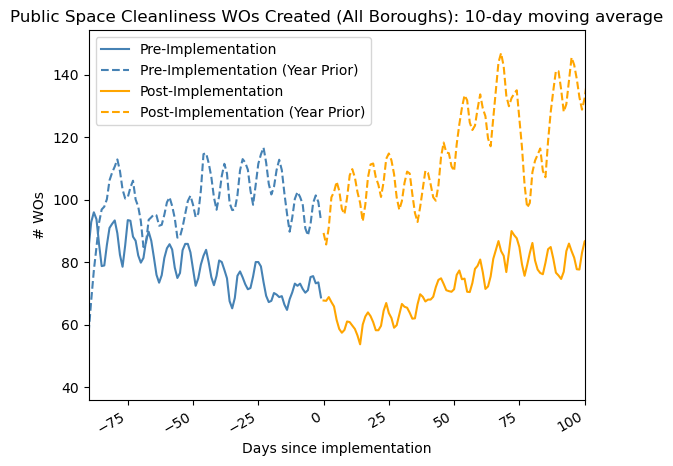

In [17]:
wo_df = wos
day_limit = None
normalize_dates = True
end_date_raw = dt.date(2022,8,24)
date_column = 'DAYS_AFTER_IMPLEMENTATION'
start_date = -90
end_date_string = 'AUG_24_'

if day_limit is not None:
    end_date = day_limit
else:
    end_date_td = end_date_raw - dt.date(2021,10,18)
    end_date = end_date_td.days
    
    
def get_day_counts(df, date_column, comp_date_column = None):
    if comp_date_column is not None:
        day_counts = df[['WONUM', 'PRE_POST_IND', date_column, comp_date_column]].groupby(date_column).agg({'WONUM': 'count', 'PRE_POST_IND':'first', comp_date_column:'first'}).reset_index()
        day_counts['7_day_rolling_avg'] = day_counts['WONUM'].rolling(10).mean()
    else:
        day_counts = df[['WONUM', 'PRE_POST_IND', date_column]].groupby(date_column).agg({'WONUM': 'count', 'PRE_POST_IND':'first'}).reset_index()
        day_counts['7_day_rolling_avg'] = day_counts['WONUM'].rolling(10).mean()
    
    def get_yoy_difference(day_counts_df, date_column = 'DAYS_AFTER_IMPLEMENTATION', yoy_date_column = 'YOY_DAYS_AFTER_IMPLEMENTATION', diff_column_list = ['WONUM', '7_day_rolling_avg']):
        def get_yoy_figure(base_date, df, yoy_date_column, data_column):
            '''Use as apply function to base date column'''
            try:
                rel_row = df[df[yoy_date_column]==base_date].iloc[0]
                return rel_row[data_column]

            except IndexError:
                return None

        for col in diff_column_list:
            new_col_name = f'PRIOR_YEAR_{col}'
            day_counts_df[new_col_name] = day_counts_df[date_column].apply(lambda x: get_yoy_figure(x, day_counts_df, yoy_date_column, col))
            #print(day_counts_df[new_col_name])
            
        return day_counts_df
    
    day_counts = get_yoy_difference(day_counts)
    
    return day_counts
    


def make_plot_wo_total(day_count_df, start_date = start_date, end_date = end_date, date_column = date_column, title='Public Space Cleanliness WOs Created by Day', normalize=True, moving_average=False):
    try:
        plt.close('all')
    except:
        pass
    if moving_average == False:
        fig = plt.subplot()
        sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
        sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
        if normalize == True:
            sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='POST'], color='orange', scatter_kws={'alpha':.3}, label = 'Post-Implementation')
            sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange', marker="None", line_kws={'linestyle':'--'}, label = 'Post-Implementation (Year Prior)')
        if normalize == False:
            sns.scatterplot(x=date_column, y='WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange')
        #sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date], color='darkorange')
    elif moving_average == True:
        fig = plt.subplot()
        sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', label = 'Pre-Implementation')
        sns.lineplot(x=date_column, y='PRIOR_YEAR_7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', **{'linestyle':'--'}, label = 'Pre-Implementation (Year Prior)')
        if normalize == True:
            sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange', label='Post-Implementation')
            sns.lineplot(x=date_column, y='PRIOR_YEAR_7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange', **{'linestyle':'--'}, label='Post-Implementation (Year Prior)')
        if normalize == False:
            sns.scatterplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange')
        #sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date], color='darkorange')
    
    for label in fig.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')

    fig.set_ylabel('# WOs')
    fig.set_xlabel('Days since implementation')
    fig.set_title(title)
    fig.set_xlim(left=start_date, right=end_date)
    #fig.set_ylim(top=12, bottom=0)
    
    #Create legend handles
    pre_imp_current = mlines.Line2D([], [], color="steelblue", label='Pre-Implementation')
    pre_imp_prior = mlines.Line2D([], [], linestyle="--", color="steelblue", label='Pre-Implementation (Year Prior)')
    post_imp_current = mlines.Line2D([], [], color="orange", label='Post-Implementation')
    post_imp_prior = mlines.Line2D([], [], linestyle="--", color="orange", label='Post-Implementation (Year Prior)')
    fig.legend(handles=[pre_imp_current, pre_imp_prior, post_imp_current, post_imp_prior])

    #plt.show()
    if moving_average == False:
        plt.savefig(f"Plots/WOs/_{str(end_date_string)}_{title}.png", bbox_inches='tight', dpi=300)
    elif moving_average == True:
        plt.savefig(f"Plots/WOs/_{str(end_date_string)}_MO_{title}.png", bbox_inches='tight', dpi=300)

    return None

if normalize_dates == True:
        
    start_dates = {'Manhattan': dt.date(2022,4,3), 
                   'Queens-Staten Island': dt.date(2022,4,4),
                   'Bronx': dt.date(2022,4,17), 
                   'Brooklyn': dt.date(2022,5,16)}


    for boro in ('Manhattan', 'Queens-Staten Island', 'Bronx', 'Brooklyn', None):
        if boro is not None:
            end_date_td = end_date_raw - start_dates[boro]
            end_date = end_date_td.days

            boro_counts = get_day_counts(wo_df[wo_df['BORO']==boro], date_column, comp_date_column = 'YOY_DAYS_AFTER_IMPLEMENTATION')
            make_plot_wo_total(boro_counts, start_date = start_date, end_date = end_date, date_column = date_column, title=f'Public Space Cleanliness WOs Created ({boro})')
            make_plot_wo_total(boro_counts, start_date = start_date, end_date = end_date, date_column = date_column, title=f'Public Space Cleanliness WOs Created ({boro}): 10-day moving average', moving_average=True)
        else:
            end_date_td = end_date_raw - start_dates['Brooklyn']
            end_date = end_date_td.days
            
            boro_counts = get_day_counts(wo_df, date_column, comp_date_column = 'YOY_DAYS_AFTER_IMPLEMENTATION')
            make_plot_wo_total(boro_counts, start_date = start_date, end_date = end_date, date_column = date_column, title=f'Public Space Cleanliness WOs Created (All Boroughs)')
            make_plot_wo_total(boro_counts, start_date = start_date, end_date = end_date, date_column = date_column, title=f'Public Space Cleanliness WOs Created (All Boroughs): 10-day moving average', moving_average = True)
        
            
        print('Plots generated. Check output folder.')



/tmp/ipykernel_237998/815643947.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
/tmp/ipykernel_237998/815643947.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/815643947.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_

Plots generated. Check output folder.


/tmp/ipykernel_237998/815643947.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
/tmp/ipykernel_237998/815643947.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/815643947.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_

Plots generated. Check output folder.


/tmp/ipykernel_237998/815643947.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
/tmp/ipykernel_237998/815643947.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/815643947.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_

Plots generated. Check output folder.


/tmp/ipykernel_237998/815643947.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
/tmp/ipykernel_237998/815643947.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/815643947.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_

Plots generated. Check output folder.


/tmp/ipykernel_237998/815643947.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
/tmp/ipykernel_237998/815643947.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/815643947.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_

Plots generated. Check output folder.


/tmp/ipykernel_237998/815643947.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', label = 'Pre-Implementation')
/tmp/ipykernel_237998/815643947.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(x=date_column, y='PRIOR_YEAR_7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', **{'linestyle':'--'}, label = 'Pre-Implementation (Year Prior)')
/tmp/ipykernel_237998/815643947.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange', label='Post-Implementation')
/tmp/ipykernel_237

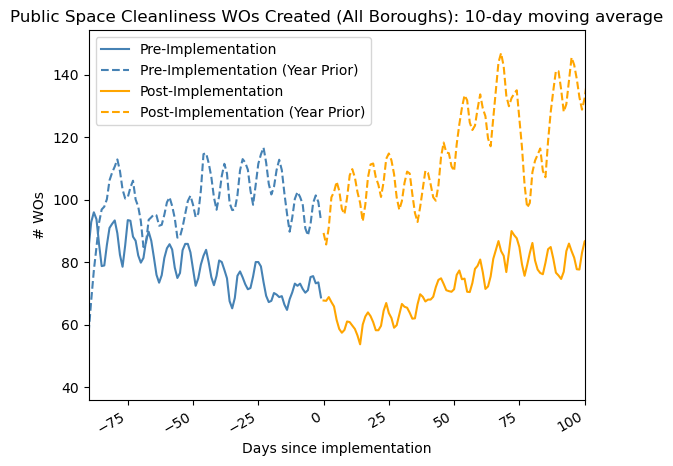

In [18]:
wo_df = wos
day_limit = None
normalize_dates = True
end_date_raw = dt.date(2022,8,24)
date_column = 'DAYS_AFTER_IMPLEMENTATION'
start_date = -90
end_date_string = 'AUG_24_'

if day_limit is not None:
    end_date = day_limit
else:
    end_date_td = end_date_raw - dt.date(2021,10,18)
    end_date = end_date_td.days
    
    
def get_day_counts(df, date_column, comp_date_column = None):
    if comp_date_column is not None:
        day_counts = df[['WONUM', 'PRE_POST_IND', date_column, comp_date_column]].groupby(date_column).agg({'WONUM': 'count', 'PRE_POST_IND':'first', comp_date_column:'first'}).reset_index()
        day_counts['7_day_rolling_avg'] = day_counts['WONUM'].rolling(10).mean()
    else:
        day_counts = df[['WONUM', 'PRE_POST_IND', date_column]].groupby(date_column).agg({'WONUM': 'count', 'PRE_POST_IND':'first'}).reset_index()
        day_counts['7_day_rolling_avg'] = day_counts['WONUM'].rolling(10).mean()
    
    def get_yoy_difference(day_counts_df, date_column = 'DAYS_AFTER_IMPLEMENTATION', yoy_date_column = 'YOY_DAYS_AFTER_IMPLEMENTATION', diff_column_list = ['WONUM', '7_day_rolling_avg']):
        def get_yoy_figure(base_date, df, yoy_date_column, data_column):
            '''Use as apply function to base date column'''
            try:
                rel_row = df[df[yoy_date_column]==base_date].iloc[0]
                return rel_row[data_column]

            except IndexError:
                return None

        for col in diff_column_list:
            new_col_name = f'PRIOR_YEAR_{col}'
            day_counts_df[new_col_name] = day_counts_df[date_column].apply(lambda x: get_yoy_figure(x, day_counts_df, yoy_date_column, col))
            #print(day_counts_df[new_col_name])
            
        return day_counts_df
    
    day_counts = get_yoy_difference(day_counts)
    
    return day_counts
    


def make_plot_wo_total(day_count_df, start_date = start_date, end_date = end_date, date_column = date_column, title='Public Space Cleanliness WOs Created by Day', normalize=True, moving_average=False):
    try:
        plt.close('all')
    except:
        pass
    if moving_average == False:
        fig = plt.subplot()
        sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', scatter_kws={'alpha':.3}, label = 'Pre-Implementation')
        sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='steelblue', label= 'Pre-Implementation (Year Prior)')
        if normalize == True:
            sns.regplot(x=date_column, y='WONUM', data=day_count_df[(day_count_df[date_column]>= start_date) & (day_count_df[date_column]<= end_date)][day_count_df['PRE_POST_IND']=='POST'], color='orange', scatter_kws={'alpha':.3}, label = 'Post-Implementation')
            sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange', marker="None", line_kws={'linestyle':'--'}, label = 'Post-Implementation (Year Prior)')
        if normalize == False:
            sns.scatterplot(x=date_column, y='WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange')
        #sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date], color='darkorange')
    elif moving_average == True:
        fig = plt.subplot()
        sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', label = 'Pre-Implementation')
        sns.lineplot(x=date_column, y='PRIOR_YEAR_7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='PRE'], color='steelblue', **{'linestyle':'--'}, label = 'Pre-Implementation (Year Prior)')
        if normalize == True:
            sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange', label='Post-Implementation')
            sns.lineplot(x=date_column, y='PRIOR_YEAR_7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange', **{'linestyle':'--'}, label='Post-Implementation (Year Prior)')
        if normalize == False:
            sns.scatterplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange')
        #sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date], color='darkorange')
    
    for label in fig.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')

    fig.set_ylabel('# WOs')
    fig.set_xlabel('Days since implementation')
    fig.set_title(title)
    fig.set_xlim(left=start_date, right=end_date)
    #fig.set_ylim(top=12, bottom=0)
    fig.legend()

    #plt.show()
    if moving_average == False:
        plt.savefig(f"Plots/WOs/_{str(end_date_string)}_{title}.pdf", bbox_inches='tight')
    elif moving_average == True:
        plt.savefig(f"Plots/WOs/_{str(end_date_string)}_MO_{title}.pdf", bbox_inches='tight')

    return None

if normalize_dates == True:
        
    start_dates = {'Manhattan': dt.date(2022,4,3), 
                   'Queens-Staten Island': dt.date(2022,4,4),
                   'Bronx': dt.date(2022,4,17), 
                   'Brooklyn': dt.date(2022,5,16)}


    for boro in ('Manhattan', 'Queens-Staten Island', 'Bronx', 'Brooklyn', None):
        if boro is not None:
            end_date_td = end_date_raw - start_dates[boro]
            end_date = end_date_td.days

            boro_counts = get_day_counts(wo_df[wo_df['BORO']==boro], date_column, comp_date_column = 'YOY_DAYS_AFTER_IMPLEMENTATION')
            make_plot_wo_total(boro_counts, start_date = start_date, end_date = end_date, date_column = date_column, title=f'Public Space Cleanliness WOs Created ({boro})')
            make_plot_wo_total(boro_counts, start_date = start_date, end_date = end_date, date_column = date_column, title=f'Public Space Cleanliness WOs Created ({boro}): 10-day moving average', moving_average=True)
        else:
            end_date_td = end_date_raw - start_dates['Brooklyn']
            end_date = end_date_td.days
            
            boro_counts = get_day_counts(wo_df, date_column, comp_date_column = 'YOY_DAYS_AFTER_IMPLEMENTATION')
            
            
            make_plot_wo_total(boro_counts, start_date = start_date, end_date = end_date, date_column = date_column, title=f'Public Space Cleanliness WOs Created (All Boroughs)')
            make_plot_wo_total(boro_counts, start_date = start_date, end_date = end_date, date_column = date_column, title=f'Public Space Cleanliness WOs Created (All Boroughs): 10-day moving average', moving_average = True)
        
            
        print('Plots generated. Check output folder.')



In [27]:
def make_yoy_charts(wo_df, end_date_raw = dt.date(2021,10,1), day_limit = None, normalize_dates = False, comp_date_column=None):
    '''Defines a single method to create charts of WOs created by day and closure time by day.
    Parameters:
        wo_df: DataFrame containing work orders of interest
        comp_df: DataFrame containing work orders in comparison geography
        end_date: datetime.Date marking the end of the period of interest
        '''
    
    end_date_string = end_date_raw.strftime("%m-%d-%Y")
    
    if normalize_dates == True:
        date_column = 'DAYS_AFTER_IMPLEMENTATION'
        start_date = -90
        if day_limit is not None:
            end_date = day_limit
        else:
            end_date_td = end_date_raw - dt.date(2021,10,18)
            end_date = end_date_td.days
        
    elif normalize_dates == False:
        date_column = 'DAY_CREATED'
        start_date = dt.date(2021,1,1)
        end_date = end_date_raw
    
    def get_day_counts(df, date_column, comp_date_column = None):
        if comp_date_column is not None:
            day_counts = df[['WONUM', 'PRE_POST_IND', date_column, comp_date_column]].groupby(date_column).agg({'WONUM': 'count', 'PRE_POST_IND':'first', comp_date_column:'first'}).reset_index()
            day_counts['7_day_rolling_avg'] = day_counts['WONUM'].rolling(10).mean()
        else:
            day_counts = df[['WONUM', 'PRE_POST_IND', date_column]].groupby(date_column).agg({'WONUM': 'count', 'PRE_POST_IND':'first'}).reset_index()
            day_counts['7_day_rolling_avg'] = day_counts['WONUM'].rolling(10).mean()

        def get_yoy_difference(day_counts_df, date_column = 'DAYS_AFTER_IMPLEMENTATION', yoy_date_column = 'YOY_DAYS_AFTER_IMPLEMENTATION', diff_column_list = ['WONUM', '7_day_rolling_avg']):
            def get_yoy_figure(base_date, df, yoy_date_column, data_column):
                '''Use as apply function to base date column'''
                try:
                    rel_row = df[df[yoy_date_column]==base_date].iloc[0]
                    return rel_row[data_column]

                except IndexError:
                    return None

            for col in diff_column_list:
                new_col_name = f'PRIOR_YEAR_{col}'
                day_counts_df[new_col_name] = day_counts_df[date_column].apply(lambda x: get_yoy_figure(x, day_counts_df, yoy_date_column, col))
                #print(day_counts_df[new_col_name])

            return day_counts_df

        day_counts = get_yoy_difference(day_counts)

        return day_counts
    
    
    day_counts = get_day_counts(wo_df, date_column, comp_date_column)
   
    def make_plot_wo_total(day_count_df, start_date = start_date, end_date = end_date, date_column = date_column, title='Public Space Cleanliness WOs Created by Day', normalize=True):
        try:
            plt.close('all')
        except:
            pass

        fig = plt.subplot()
        sns.regplot(x=date_column, y='WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='PRE'], color='blue')
        sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='blue')
        if normalize == True:
            sns.regplot(x=date_column, y='WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange')
            sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange', marker="None", line_kws={'linestyle':'--'})
        if normalize == False:
            sns.scatterplot(x=date_column, y='WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange')
        #sns.lineplot(x=date_column, y='7_day_rolling_avg', data=day_count_df[day_count_df[date_column]>= start_date], color='darkorange')

        for label in fig.get_xticklabels():
            label.set_rotation(30)
            label.set_ha('right')

        fig.set_ylabel('# WOs')
        fig.set_xlabel('Days since implementation')
        fig.set_title(title)
        fig.set_xlim(left=start_date, right=end_date)
        #fig.set_ylim(top=12, bottom=0)

        #plt.show()
        plt.savefig(f"Plots/WOs/{str(end_date_string)}_{title}.pdf", bbox_inches='tight')

        return None
    
    
    if normalize_dates == False:
        #make_plot_wo_total(day_counts, start_date = start_date, end_date = end_date, date_column = date_column, title='NN_Public Space Cleanliness WOs Created (Pilot Sites)')
        
        start_dates = {'Manhattan': dt.date(2022,4,3), 
                       'Queens-Staten Island': dt.date(2022,4,4),
                       'Bronx': dt.date(2022,4,17), 
                       'Brooklyn': dt.date(2022,5,1)}
    
        
        for boro in ('Manhattan', 'Queens-Staten Island', 'Bronx', 'Brooklyn'):
            end_date = end_date_raw
            
            boro_counts = get_day_counts(wo_df[wo_df['BORO']==boro], date_column)
            make_plot_wo_total(boro_counts, start_date = start_date, end_date = end_date, date_column = date_column, title=f'NN_Public Space Cleanliness WOs Created ({boro})', normalize=False)

        #make_plot_time_to_close(time_to_close_by_day, start_date = start_date, end_date=end_date, title='Time To Close Public-Space Cleanliness Work Orders by Day since Pilot Start')
        
        end_date_td = end_date_raw
        end_date = end_date_raw

        
    if normalize_dates == True:
        
        start_dates = {'Manhattan': dt.date(2022,4,3), 
                       'Queens-Staten Island': dt.date(2022,4,4),
                       'Bronx': dt.date(2022,4,17), 
                       'Brooklyn': dt.date(2022,5,1)}
    
        
        for boro in ('Manhattan', 'Queens-Staten Island', 'Bronx', 'Brooklyn'):
            end_date_td = end_date_raw - start_dates[boro]
            end_date = end_date_td.days
            
            boro_counts = get_day_counts(wo_df[wo_df['BORO']==boro], date_column, comp_date_column = comp_date_column)
            make_plot_wo_total(boro_counts, start_date = start_date, end_date = end_date, date_column = date_column, title=f'YOY_COMP_Public Space Cleanliness WOs Created ({boro})')
    
    print('Plots generated. Check output folder.')
    
    return None

    

/tmp/ipykernel_237998/3371062241.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='PRE'], color='blue')
/tmp/ipykernel_237998/3371062241.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='PRIOR_YEAR_WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='PRE'], marker="None", line_kws={'linestyle':'--'}, color='blue')
/tmp/ipykernel_237998/3371062241.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column, y='WONUM', data=day_count_df[day_count_df[date_column]>= start_date][day_count_df['PRE_POST_IND']=='POST'], color='orange')
/tmp/ipykernel_237998/3371062241.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(x=date_column,

Plots generated. Check output folder.


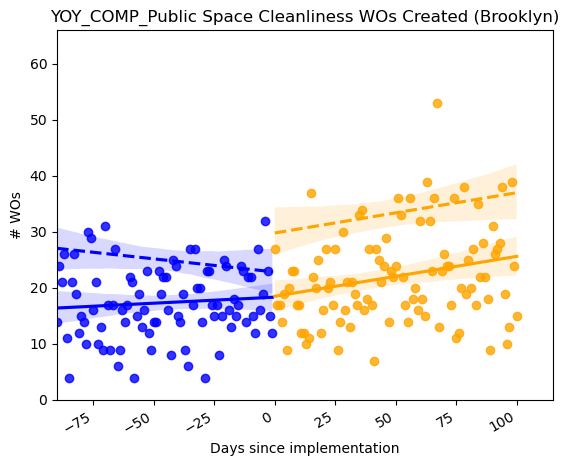

In [29]:
make_yoy_charts(wos, end_date_raw = dt.date(2022,8,24), day_limit = None, normalize_dates = True, comp_date_column='YOY_DAYS_AFTER_IMPLEMENTATION')
